Here’s a clear and simple explanation of **LangGraph** — the new low-level orchestration framework (sometimes referred to as “Langraf”) in LangChain—focusing on its three core components: **State**, **Node**, and **Edge**.

---

## What is LangGraph?

LangGraph lets you build workflows and agents as **graphs**. Each graph is a set of connected steps (called nodes) that process data (the state) and pass it along via connections (edges). It’s great for creating dynamic, long-running, or looping workflows in a clear, modular way.([LangChain AI][1], [LangChain Blog][2])

---

## Core Concepts

### 1. **State**

The **state** is a shared data structure (like a dictionary or typed object) that represents the current snapshot of everything the graph knows. It moves from node to node throughout execution.([Medium][3], [LangChain AI][4])

* **Schema:** Usually defined with a `TypedDict` or `Pydantic` model so nodes know what structure to expect.([Medium][3], [LangChain AI][4])
* Can handle both replacing values and appending to them as the graph runs.([LangChain Blog][2])

### 2. **Node**

A **node** is where the actual work happens. Each node is typically a function or runnable component that:

* Takes the current state,
* Does some operation (e.g., call an LLM, perform computation),
* Returns updates to the state.([Medium][5], [LangChain AI][4], [LangChain Blog][2])

### 3. **Edge**

An **edge** defines how data flows between nodes—it specifies which node runs next:

* **Normal edges**: Always go from Node A → Node B.([LangChain Blog][2], [LangChain AI][4])
* **Conditional edges**: Use a function to decide next node based on current state.([LangChain Blog][2], [LangChain AI][4])
* **Entry point**: Where the graph starts (initial node).([LangChain Blog][2], [LangChain AI][4])
* **END node**: Represents termination of the graph flow.([LangChain Blog][2], [LangChain AI][4])

You can also send messages to dynamically create nodes (advanced workflows like map-reduce), or use `Command` to both update state and control flow in one go.([LangChain AI][4], [LangChain Blog][2])

---

## Putting It All Together: A Simple Example

```python
from typing import TypedDict
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    input: str
    result: str

# Define the graph
graph = StateGraph(State)

# 1. Add nodes
def node1(state: State) -> dict:
    return {"result": state["input"].upper()}

def node2(state: State) -> dict:
    return {"result": f"Processed: {state['result']}"}

graph.add_node("to_upper", node1)
graph.add_node("postprocess", node2)
graph.add_node("end", lambda state: {})

# 2. Define flow
graph.add_edge(START, "to_upper")
graph.add_edge("to_upper", "postprocess")
graph.add_edge("postprocess", END)

# 3. Compile the graph into a runnable
app = graph.compile()

# 4. Run it
output = app.invoke({"input": "hello world"})
print(output)  # State showing 'result': "Processed: HELLO WORLD"
```

---

## Why this design is powerful

* **Modular**: Nodes only care about the state they receive and what they output—clean and reusable.
* **Flexible flow**: You can build linear or branching workflows using edges and conditional logic.
* **Unified interface**: After compilation, the graph behaves like any LangChain `Runnable` (supports `.invoke()`, streaming, batching, etc.).([LangChain Blog][2])
* **Advanced capabilities**: You can integrate caching, loops, retries, human-in-the-loop checkpoints, and robust, persistent workflows.([LangChain AI][1], [LangChain Blog][2])

---

## Summary Table

| Component | Role                                                         |
| --------- | ------------------------------------------------------------ |
| **State** | Shared data that threads through the graph; updated by nodes |
| **Node**  | Executes some logic and returns updates to the state         |
| **Edge**  | Determines which node runs next—can be fixed or conditional  |

---



In **LangGraph**,
**conditional edges** are connections between nodes where the next step depends on a condition — like an **if/else** in programming.

They let you **branch the conversation flow or workflow** based on some state, model output, or logic.

---

### **How it works**

1. You define **nodes** (each does some work — e.g., LLM call, tool call).
2. You connect nodes with **edges**.
3. For **conditional edges**, you give LangGraph a **function** that inspects the state and returns the name of the next node.

---

### **Example:**

```python
from langgraph.graph import StateGraph, START, END
from typing import TypedDict

# Define state
class State(TypedDict):
    user_input: str

# Example functions
def ask_question(state: State):
    return {"user_input": input("You: ")}

def positive_response(state: State):
    print("Bot: That's great! 😊")
    return {}

def negative_response(state: State):
    print("Bot: Oh no! 😟")
    return {}

# Decide where to go next
def decide_path(state: State):
    if "good" in state["user_input"].lower():
        return "positive"
    else:
        return "negative"

# Build the graph
graph = StateGraph(State)
graph.add_node("ask", ask_question)
graph.add_node("positive", positive_response)
graph.add_node("negative", negative_response)

graph.add_edge(START, "ask")

# Conditional edge from "ask"
graph.add_conditional_edges(
    "ask",
    decide_path,
    {
        "positive": "positive",
        "negative": "negative",
    },
)

graph.add_edge("positive", END)
graph.add_edge("negative", END)

app = graph.compile()
app.invoke({})
```

---



Absolutely! Let’s dive into **Tools in LangGraph (LangChain’s low-level orchestration framework)** in a simple and clear way, with code to illustrate how they integrate with your LangGraph workflows.

---

## What Are Tools in LangGraph?

In LangGraph, **tools** are like external helper functions — they can fetch data, perform calculations, or call services. You integrate them into your graph so the flow can invoke them when needed.

---

## Why Tools Matter in LangGraph

* They let the agent do real-world stuff like getting weather info or performing math.
* They can be built-in utilities or custom functions you define.
* When a tool is called, it interacts smoothly with your graph’s state and logic.
  ([LangChain AI][1], [Medium][2], [GitHub][3])

---

## Simple Steps to Use Tools in LangGraph

### 1. Define a Tool with `@tool` (from LangChain)

```python
from langchain_core.tools import tool

@tool
def get_weather(location: str) -> str:
    """Return the current weather for a location."""
    return f"It's sunny in {location}!"
```

This creates a tool with metadata (name, description, input schema) automatically.
([LangChain][4])

---

### 2. Integrate with LangGraph via `ToolNode` and `bind_tools`

```python
from langchain.chat_models import init_chat_model
from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, MessagesState, START, END

# Create the tool node
tool_node = ToolNode([get_weather])

# Attach tool schema to the model
model = init_chat_model(model="claude-3-5-haiku-latest")
model_with_tools = model.bind_tools([get_weather])
```

Here, the model can now decide to call tools while generating responses.
([LangChain AI][1])

---

### 3. Build a Graph That Uses Tools

Set up a simple LangGraph workflow that can branch to the tool:

```python
# Determine whether to use the tool or finish
def should_call_tool(state: MessagesState):
    last = state["messages"][-1]
    # If model decided to invoke a tool, switch to tool_node
    if last.tool_calls:
        return "tools"
    return END

# Node that sends messages through the LLM
def run_model(state: MessagesState):
    response = model_with_tools.invoke(state["messages"])
    return {"messages": [response]}

# Build the graph
builder = StateGraph(MessagesState)
builder.add_node("run_model", run_model)
builder.add_node("tools", tool_node)
builder.add_edge(START, "run_model")
builder.add_conditional_edges("run_model", should_call_tool, ["tools", END])
builder.add_edge("tools", "run_model")

graph = builder.compile()

# Run the graph
result = graph.invoke({
    "messages": [{"role": "user", "content": "What's the weather in Bangalore?"}]
})
print(result)
```

This loop lets the agent:

1. Respond or decide it needs a tool.
2. If so, call the tool to get data.
3. Then return to reasoning with that info.
   ([LangChain AI][1], [Medium][2])

---

## Summary Table

| Step                 | Purpose                                                           |
| -------------------- | ----------------------------------------------------------------- |
| `@tool` decorator    | Turn a Python function into a callable tool with schema           |
| `ToolNode`           | Wraps tool for use within a LangGraph workflow                    |
| `model.bind_tools()` | Enables the model to choose and use tools during reasoning        |
| Graph construction   | Integrates tool decisions into the workflow via conditional edges |

---

## Recap in Plain English

* **Tool**: A helper function (like “get weather,” “fetch stock price”).
* **ToolNode**: Plugs that helper into your graph.
* **Model with tools**: Lets the LLM decide to call the helper when needed.
* **Workflow**: The graph decides when to use the tool and loops back to reasoning with the tool’s output.

---



# react agrnt

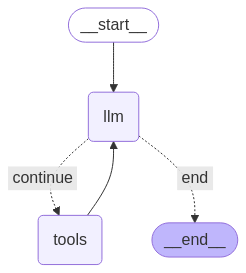

# Agintic Rag

## Arag

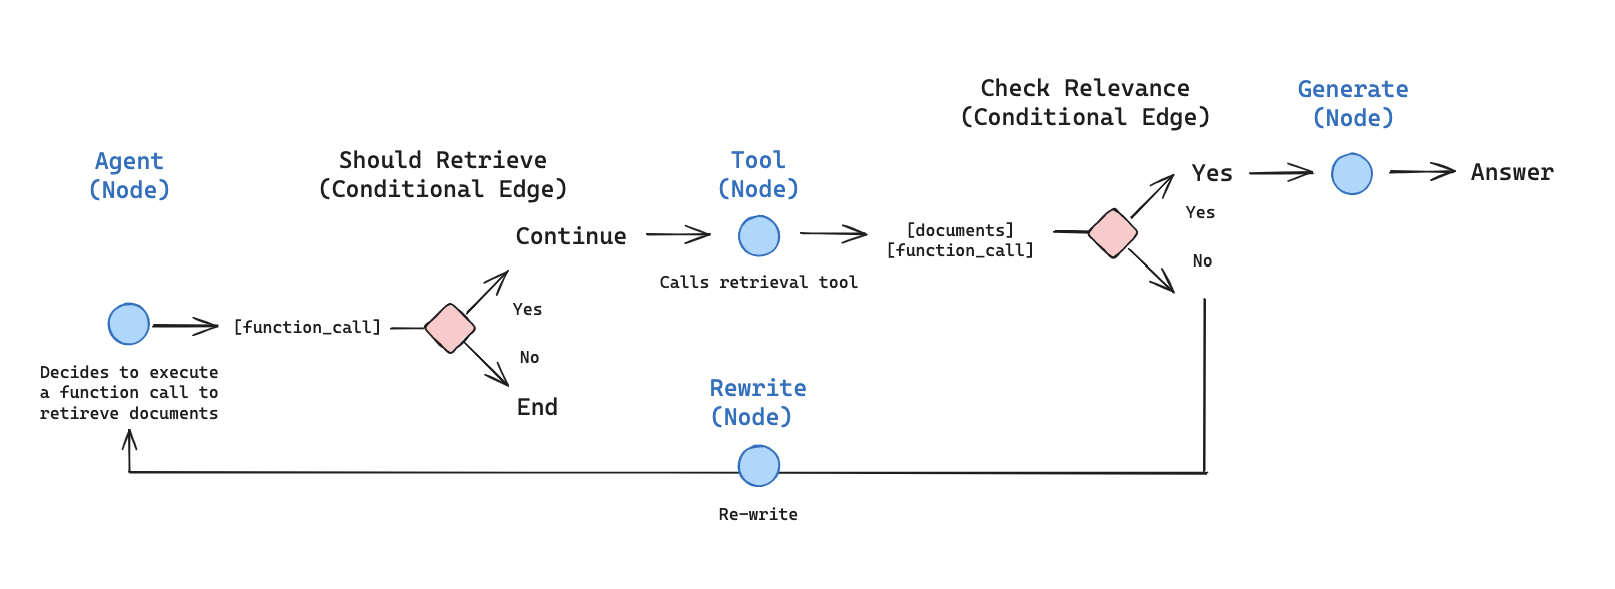

## crag

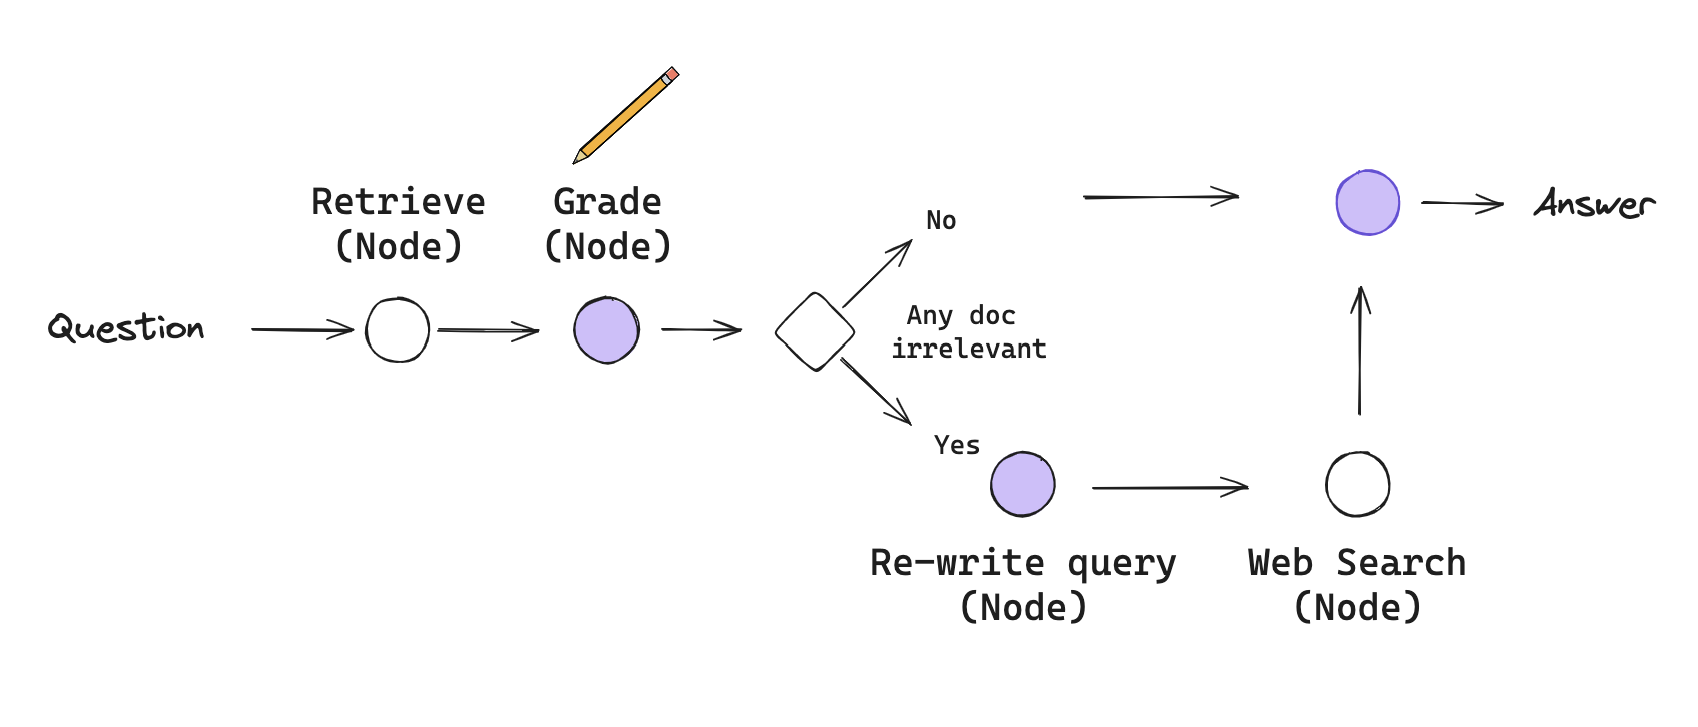

## self rag

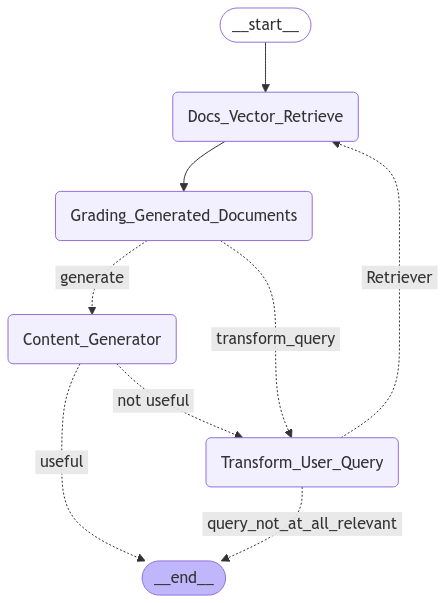

# agent models

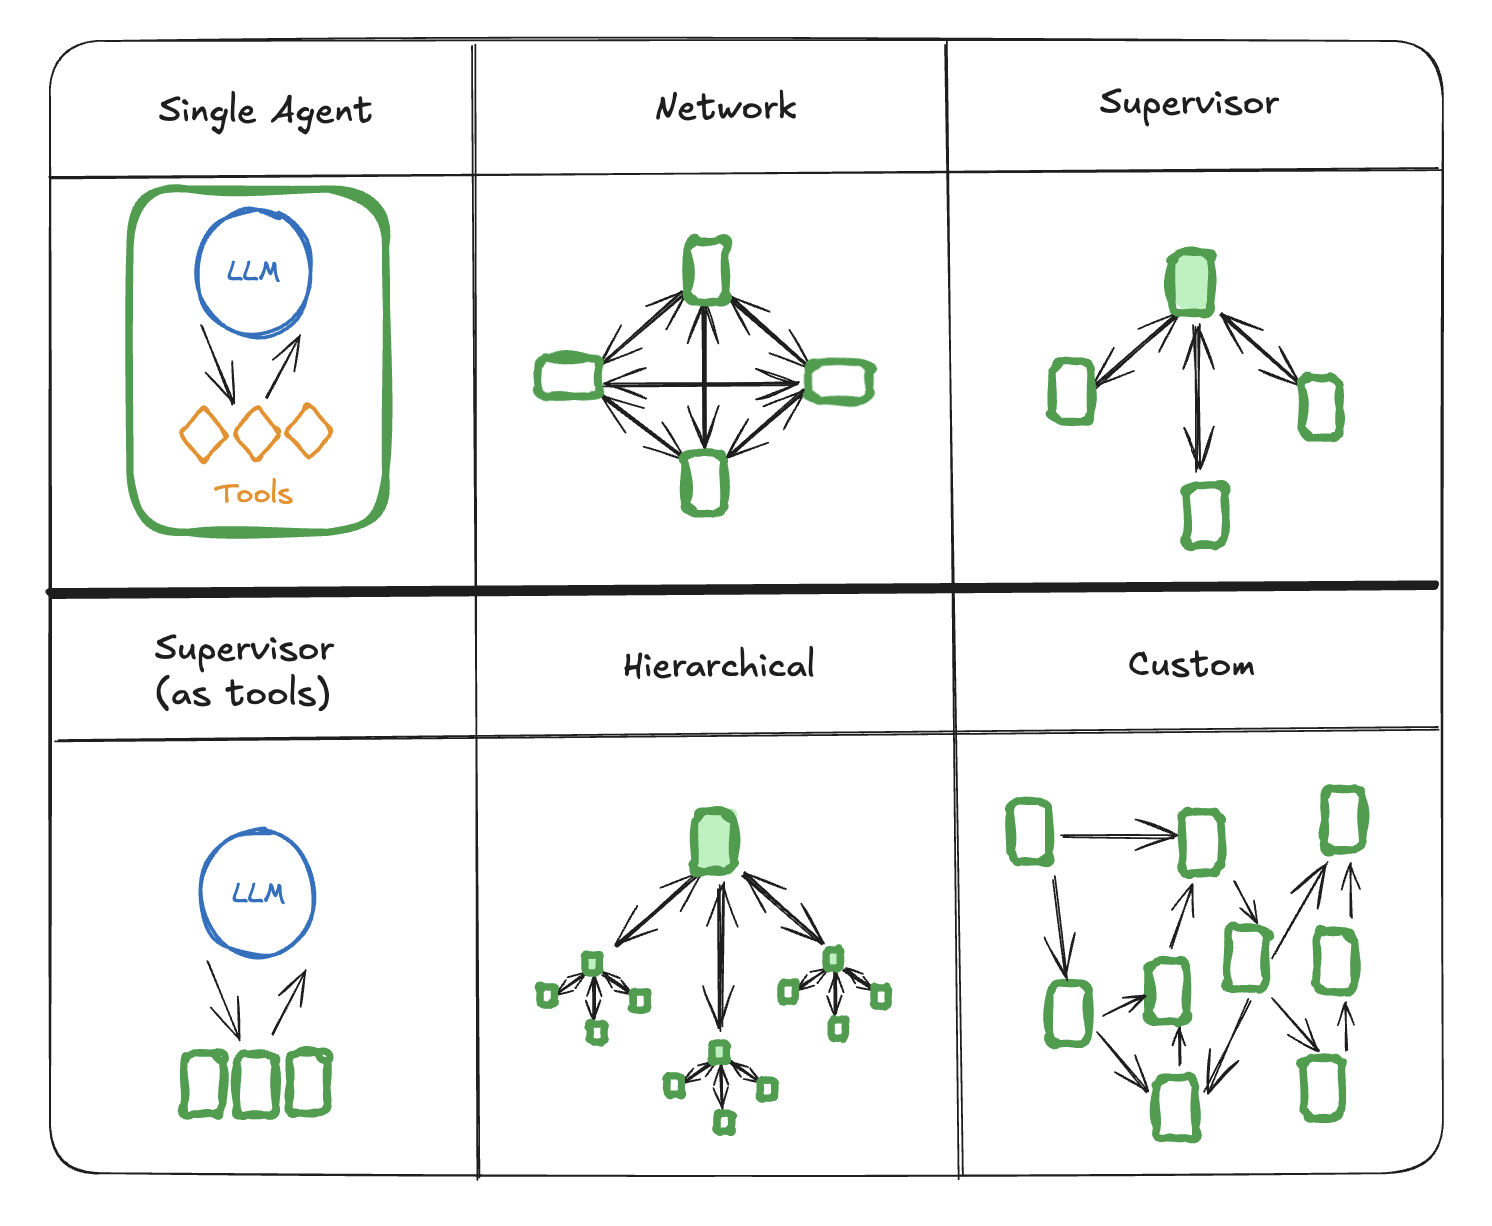